# Intro to Random Forests - BlueBook for Bulldozers

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "data/bulldozers/"

In [4]:
!ls {PATH}

random_forest_benchmark_test.csv  Train.csv  Valid.csv


# Introduction to *Blue Book for Bulldozers*

The [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers) Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

A common type of dataset and prediction problem.

## The data

### Look at the data

Kaggle provides info about some of the fields of our dataset; 
the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) says:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

*Question*

What stands out to you from the above description?  What needs to be true of our training and validation sets?

`parse_dates` — list of any columns that contain dates
`low_memory=False` — Forces it to read more of the file to decide what the types are.

In [5]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

Always **look at the data**, understand the format, how it's stored, what type of values it holds, etc. 
Even after reading descriptions of the data, the actual data may not be what we expect.

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [7]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [8]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Metric: 
Note what metric is being used. Generally, selecting the metric(s) is part of the project setup. 
However, Kaggle tells us what metric to use: RMSLE (root mean squared **Log** error) between the actual and predicted auction prices. 
Therefore we take the log of the prices, so that RMSE will give us what we need.

In [9]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### Initial processing

In [10]:
m = RandomForestRegressor(n_jobs=-1)

Below `m.fit` will fail with 
*ValueError: could not convert string to float: 'Conventional'*
as the data is not yet ready...

In [11]:
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'Conventional'

We have to pass numbers to most ML models and certainly to random forests. 
So step 1 is to convert everything into numbers.

This dataset contains a mix of **continuous** and **categorical** variables.

`add_datepart` extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  
Always consider this feature extraction step when working with date-time. 
Without expanding the date-time into these additional fields, 
we can't capture any trend/cyclical behavior as a function of time at any of these granularities.

Some of the information we can extract from date: year, month, quarter, day of month, day of week, week of year, is it a holiday? weekend? was it raining? was there a sport event that day? 
It really depends on what we are doing, e.g., for predicting soda sales, was there a ball game that day?
What is in a date is one of the most important pieces of feature engineering.
No ML algorithm can tell if there was a ball game that day and that it was important. 

In [12]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

After running, `add_datepart` added many numerical columns and removed the `saledate` column. 

This is not enough to pass the earlier error, as we still have other columns that contain string values. 
Pandas has a category data type, but by default it would not turn anything into a category. 
Fast.ai `train_cats` creates categorical variables for all Strings. 
It creates an integer column and stores a mapping from the integers to the strings. 
`train_cats` is called “train” because it is training data specific. 

**NB:** validation and test sets should use the same category mappings (i.e., 1 for “high” in training dataset, then 1 should also be for “high” in validation and test datasets). 
For validation and test dataset, use `apply_cats` instead.

The categorical variables are (inneficiently) stored as strings, and do not provide the numeric coding required for a random forest. 
We call `train_cats` (from fastai/structured.py) to convert **in place** any columns of strings in a panda's dataframe to a column of catagorical values. 

In [13]:
train_cats(df_raw)

In [14]:
df_raw.columns   # Take a look at the columns of the df

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [15]:
df_raw.UsageBand.cat.categories   #Notice that the categories are not "ordered" in a logical way...

Index(['High', 'Low', 'Medium'], dtype='object')

 So we can specify the order to use for categorical variables (if we wish):

In [16]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [17]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

We're still not quite done - for instance we have lots of missing values, that we can't pass directly to a random forest.

In [18]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))   # See the % of missing variables for each column

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

The above will add a number of empty values for each series, we sort them by the index (pandas.Series.sort_index), and divide by the (number of rows) in the dataset.

Reading the source CSV took about 10 seconds, and processing took another 10 seconds.
To avoid that wait again, we save them in the feather format, in the same basic format that it is in RAM. 
This is the fastest way to save and to read it back. 
Let's save this file for now, (using feather), since it's already in a format that can we be stored and accessed efficiently.

In [19]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

### Pre-processing

In the future we can simply read it from this fast format.

In [20]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

We'll use `proc_df` from structured.py to:
- replace categories with their numeric codes, 
- handle missing continuous values, and 
- split the dependent variable into a separate variable.

Signature: `proc_df`(df, y_fld=None, skip_flds=None, do_scale=False, na_dict=None, preproc_fn=None, max_n_cat=None, subset=None, mapper=None)

Docstring:
`proc_df` takes a data frame df and splits off the response variable, and changes the df into an entirely numeric dataframe.

Returns: x, y, nas
- `x` is the transformed version of df. x will not have the response variable and is entirely numeric.
- `y` is the response variable
- `nas`: returns a dictionary of which nas it created, and the associated median.

In [21]:
df, y, nas = proc_df(df_raw, y_fld='SalePrice')  #returned df does not include the response variable. y is the actual.

We now have a df that we can pass to a RF!

[RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

A RF is a meta estimator that fits a number of classifying
decision trees on various sub-samples of the dataset and use averaging
to improve the predictive accuracy and control over-fitting.
The sub-sample size is always the same as the original
input sample size but the samples are drawn with replacement if `bootstrap=True` (default).

RFs are trivially parallelizable, we can split up the data across different CPUs and it linearly scale. 
`n_jobs=-1` tells the RF regressor to create a separate job/process for each CPU you have.

In [22]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)  # Build a forest of trees from the training set (df, y).
m.score(df,y) # Returns the coefficient of determination R^2 of the prediction.

0.9830500427288952

`m.score` return $R^2$ value (1 is good, 0 is bad).


[Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) defines  $R^2$ "R squared": as the proportion of the variance in the dependent variable that is predictable from the independent variable(s). Important cases where the computational definition of $R^2$ can yield negative values, depending on the definition used, arise where the predictions that are being compared to the corresponding outcomes have not been derived from a model-fitting procedure using those data, and where linear regression is conducted without including an intercept. Additionally, negative values of $R^2$ may occur when fitting non-linear functions to data.[6] In cases where negative values arise, the mean of the data provides a better fit to the outcomes than do the fitted function values, according to this particular criterion.[7] 

$R^2$ is a statistic that will give some information about the goodness of fit of a model. In regression, the $R^2$ coefficient of determination is a statistical measure of how well the regression line approximates the real data points. An $R^2 = 1$ indicates that the regression line perfectly fits the data.

What is the possible range of $R^2$?
[14:43]?
Correct answer: Anything equal to or less than 1. If you predicted infinity for every row, R² = 1 −∞

So when your $R^2$ is negative, it means the model is worse than predicting the mean.

$R^2$ is not what we are trying to optimize, but it is a number we can use for every model, to get a feel of what .8 or what .9 looks like. 

TODO: create synthetic 2D datasets with different amounts of random noise, and see what they look like on a scatterplot and their $R^2$ to get a feel of how close they are to the actual value.

$R^2$ is the ratio between how good the model is (RMSE) vs. how good is the naïve mean model (RMSE).

$ R^2 $ of 0.98 - that's great, right? Well, perhaps not... (could overfit)

In [23]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()   # returns the first n elements and the elements after n

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)   # split a validation set of 12000
X_train, X_valid = split_vals(df, n_trn)        # from the df, split a validation set
y_train, y_valid = split_vals(y, n_trn)         # from the y split a validation set

len(df), n_trn, X_train.shape, y_train.shape, X_valid.shape

(401125, 389125, (389125, 66), (389125,), (12000, 66))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [24]:
def rmse(predictions, actuals): 
    return math.sqrt(((predictions-actuals)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train),  #training set
           rmse(m.predict(X_valid), y_valid),  #validation set
           m.score(X_train, y_train),  # R^2 for training
           m.score(X_valid, y_valid)]  # R62 for validation
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print("RMSE Train\t\tValid\t\t   R2 train\t\tR2 valid\t\t OOB\n", res)

In [25]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 20s, sys: 320 ms, total: 1min 20s
Wall time: 10 s
RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.09043164574229756, 0.24616573177654233, 0.9829086764733415, 0.8917810875608566]


An $R^2$ in the high-80's isn't bad (the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard). <br>
But we can see from the "R2 valid" set score that we're over-fitting badly as R2 train >> R2 Valid. 
To understand this issue, let's simplify things down to a single small tree.

## Speeding things up
Execution Time [29:29]
If you put %time, it will tell you how long things took. The rule of thumb is that if something takes more than 10 seconds to run, it is too long to do interactive analysis with it. So what we do is we try to make sure that things can run in a reasonable time. And then when we are finished at the end of the day, we can say ok, this feature engineering, these hyper parameters, etc are all working well, and we will now re-run it the big slow precise way.
One way to speed things up is to pass in the `subset=` parameter to `proc_df` which will randomly sample the data:

In [26]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)   # Keep the same validation set as before by ignoring the output
y_train, _ = split_vals(y_trn, 20000)

**NB:** make sure that:
- validation set does not change, and 
- training set does not overlap with the dates.
When calling split_vals, we do not put the result to a validation set. 
`_` indicates throw away the return value. 
We want to keep the validation set the same all the time.
After resampling the training set into the first 20,000 out of a 30,000 subsets, it runs in 478 milliseconds.

In [27]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3.12 s, sys: 8.07 ms, total: 3.13 s
Wall time: 478 ms
RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.11270729669516122, 0.3422283957680788, 0.9723509136794927, 0.7908393142880177]


## Single tree

SKLearn calls trees "estimators". Lets create a small tree, a model that is better than mean, but easier to draw. <br>
We choose a single tree (`n_estimators=1`) vs the default (10). Also, limit the tree depth `max_depth=3` to 3.
`bootstrap=False` — RF randomizes bunch of things, we want to turn that off by this parameter

In [28]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.5251376253339611, 0.5814954282436393, 0.3997626863929399, 0.3961339924824332]


This small deterministic tree has R² of 0.39 after fitting, so is not a good model but better than the mean model and we can actually draw it [33:00]: <br>
`draw_tree` Draws a representation of a random forest in IPython.
`draw_tree` from Fastai structured.py required to conda install graphviz, and also to apt install it

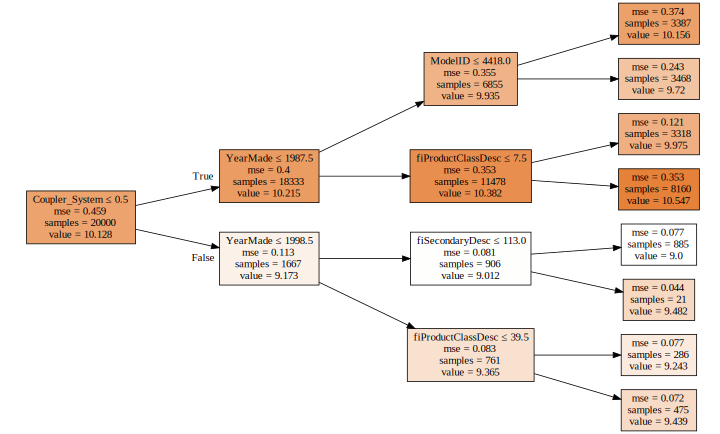

In [29]:
draw_tree(m.estimators_[0], df_trn, precision=3)

A tree consists of a sequence of binary decisions.

- The first line indicates the binary split criteria
- samples at the root is 20,000 as specified when splitting the data.
- Darker color indicates higher value.
- value is average of the log of price.

If we built a model where we just used the average all the time, then the mean squared error (mse) would be as indicated in the box (e.g. 0.459)
The best single binary split we can make turns out to be Coupler_system ≤ 0.5,
which will improve mse to (0.113) in false path; 0.40 in true path.

We want to start building a RF from scratch [36:28]. 
The first step is to create a tree. 
The first step to create a tree is to create the first binary decision. 
We need to pick a variable and the value to split on such that the two groups are 
**as different to each other as possible**.
For each variable, for each possible value of that variable see whether it is better.
To determine if it is better, take the weighted average of two new nodes. <br>
The resulting model will be similar to the naïve model of means — we have a model with a single binary decision. 
For everybody with coupler_system greater than 0.5, we will fill in 10.215, 
for everybody else, we will put 9.173. <br>
Then we will calculate RMSE of this model.
We now have a single number that represents how good a split is: 
the weighted average of the MSEs of the two groups that creates [42:13]. 
We also have a way to find the best split: try every variable and to every possible value of that variable 
and see which variable and which value gives us a split with the best score.

Stopping condition:
- When we hit the limit (max_depth)
- When leaf nodes only have one thing in them

Let's see what happens if we create a bigger tree (by removing the max depth parameter).
Right now, our decision tree has R² of 0.4. Let’s make it better by removing max_depth=3. 
The training R² becomes 1 (as expected since each leaf node contains exactly one element) and validation R² is (0.601) — better than the shallow tree but not as good as we would like.

In [30]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [7.215595591812694e-17, 0.4586010692717244, 1.0, 0.6244064721595722]


The training set result looks great! But the validation set is worse than our original model. <br>
Next we use *bagging* of multiple trees to get more generalizable results.

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.  RF is a way to bagging trees.

In [31]:
m = RandomForestRegressor(n_jobs=-1)   #by default it creates 10 estimators (trees)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.11219349213232521, 0.35111959940201765, 0.9726024297001296, 0.7798300120375808]


We'll grab the predictions for each individual tree, and look at one example.
After building a RF, each tree is stored in `m.estimators_`
We will use list comprehenssion to go thru each tree (t) in the model.
Then call `t.predict()` of each model to get a list of arrays of predictions.
Each array will be all of the predictions for that tree (and there are 10 trees). <br>
`np.stack` concatenates them together on a (new?) axis

In [32]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([8.92266, 9.10498, 9.25913, 9.3501 , 9.30565, 9.82553, 8.92266, 9.4727 , 9.54681, 9.3501 ]),
 9.306032542810346,
 9.104979856318357)

Notice above the predictions of the 10 trees, then the mean prediction and the actual... In general the mean will (should be) better than each of the individual tree predictions... *but it is not in this case...*

In [33]:
preds.shape

(10, 12000)

Now plot the $R^2$ scores using 1 tree, mean of 2 trees, ..., mean of i tries. 
As we add more estimators, $R^2$ improves.

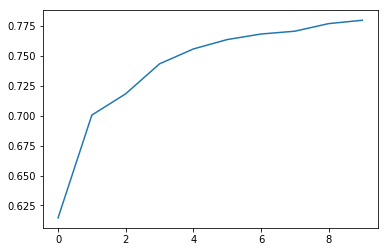

In [34]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help much. 
Let's check by doing 20 estimators. (Compare this to our original model on a sample)

In [35]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6.14 s, sys: 12.2 ms, total: 6.15 s
Wall time: 790 ms
RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.10111942747730364, 0.3373842291765527, 0.9777440610216795, 0.796718653017909]


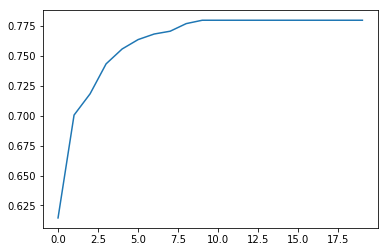

In [36]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(20)]);

In [37]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.0957464535075981, 0.33767228076356937, 0.9800463609980865, 0.7963713901272405]


In [38]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.09392124225792112, 0.33279356470252897, 0.980799860939317, 0.8022129680765654]


Adding more trees does not help much. 
It will not get worse but it will stop improving much. 
The 
** number of estimators ** is a hyper parameter to learn to set:
A method of setting is, as many as we have time to and seems to help.

Adding more trees slows it down, but with less trees you can still get the same insights. 
So start with 20-30 trees and at the end of the project (or end of the day) use 1000 trees and run it over night.

### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. 
However, RFs have a very clever trick called **out-of-bag (OOB) error** which can handle this (and more!)

The idea is to calculate error on the training set, 
but **only include the trees in the calculation of a row's error where that row was *not* included in training that tree.** 
This allows us to see whether the model is over-fitting, without needing a separate validation set.

It shows whether the model generalizes, even if we only have a small amount of data 
(so want to avoid separating some out to create a validation set).

This is done by adding `oob_score=True` to the model constructor. 
We print the OOB error last in our `print_score` function below.

**OOB score will be useful when setting hyper parameters** [1:13:47]. 
We are going to set a few hyper parameters, and would like to find some automated way to set them. 
One way is to do grid search. 
Scikit-learn has a function called grid search.
We pass in a list of all the hyper parameters we want to tune and all of the values of these hyper parameters we want to try. 
It will run the model on every possible combination of all these hyper parameters and tell which one is the best. 
OOB score is a great choice for getting it to tell you which one is the best.

`RandomForestRegressor` 
- `oob_score` : bool, optional (default=False) whether to use out-of-bag samples to estimate the $R^2$ on unseen data.
- `n_jobs` : integer, optional (default=1) The number of jobs to run in parallel for both `fit` and `predict`.
If -1, then the number of jobs is set to the number of cores.

In [39]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 12.7 s, sys: 4.04 ms, total: 12.7 s
Wall time: 1.42 s
RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.09664197886579545, 0.3306265070168286, 0.9796713590172001, 0.8047804479807268, 0.8561208986142269]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

An easy way to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. 
Let's return to using the full dataset to demonstrate the impact of this technique.

In [40]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [41]:
len(df_trn), len(X_train)

(401125, 389125)

Rather than limit the total amount of data that the model can access, 
**let's instead limit it to a *different* random subset per tree.**
Given enough trees, the model can still see *all* the data, 
but for each individual tree it'll be as fast as if we had cut down the dataset as before.

Earlier, we took 30,000 rows and created all the models which used a different subset of that 30,000 rows. 
Now, lets take a **different subset** of 30,000 each time.
We leave the entire 389,125 records as is, and to make things faster, we pick a different subset of 30,000 each time. 
So rather than bootstrapping the entire set of rows, just randomly sample a subset of the data.

In [42]:
set_rf_samples(20000)   #fastai hack to sckit

Scikit-learn does not support this,
`set_rf_samples` is a fastai custom function. 
So OOB score needs to be turned off when using `set_rf_samples` as they are not compatible. 
`reset_rf_samples()` will turn it back to the way it was.

In [43]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 8.5 s, sys: 484 ms, total: 8.98 s
Wall time: 3.4 s
RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.24040723098702418, 0.28452340156423434, 0.879210306676051, 0.8554280768033773, 0.8665626924954033]


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [44]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 33.7 s, sys: 1.31 s, total: 35 s
Wall time: 9.45 s
RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.22763685720331847, 0.26163735701735397, 0.8917021117646562, 0.8777503904474535, 0.880143331425955]


This takes the same amount of time to run as before, but every tree has access to the entire dataset. 
After using 40 estimators, we get the R² score of 0.876.

### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [45]:
reset_rf_samples()   #get back to the full dataset

#### baseline
Let's get a baseline for this full set to compare to.

In [46]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 55s, sys: 1.21 s, total: 5min 56s
Wall time: 37.9 s
RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.0782034211007102, 0.23747632333614566, 0.9872183673818934, 0.8992862871023412, 0.9085538602245298]


Here OOB is higher than validation set. This is because our validation set is a different time period whereas OOB samples are random. It is much harder to predict a different time period.

#### min_sample
Another way to reduce over-fitting is to grow our trees less deeply, 
by specifying (with `min_samples_leaf`) a minimum number of rows in every leaf node. 
This has two benefits:
- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

For `min_samples_leaf` use: 1, 3, 5, 10, 25, 100, keep trying from smaller to bigger while it is still improving.

In [47]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 14s, sys: 684 ms, total: 5min 14s
Wall time: 33.4 s
RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.11510233549661755, 0.23492268435578162, 0.9723112660902045, 0.9014406380383442, 0.9084646915502077]


#### max_feature
We can also increase the amount of variation amongst the trees by (not only use a sample of rows for each tree), but also using a sample of *columns* for each **split**. We do this by specifying `max_features`, the proportion of features to randomly select from at each split.

- `max_features=0.5` : The idea is that the less correlated your trees are with each other, the better. Imagine you had one column that was so much better than all of the other columns of being predictive that every single tree you built always started with that column. But there might be some interaction of variables where that interaction is more important than the individual column. So if every tree always splits on the same thing the first time, you will not get much variation in those trees.
- In addition to taking a subset of rows, at every single split point, take a different subset of columns.
For row sampling, each new tree is based on a random set of rows, for column sampling, every individual binary split, we choose from a different subset of columns.
- 0.5 means randomly choose a half of them. 

For `max_features` JH recommends 
- None (all of the features)
- 0.5
- 'sqrt'
- 'log'

In [48]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		Valid		   R2 train		R2 valid		 OOB
 [0.11920249150209167, 0.2287663109839011, 0.9703034846136184, 0.9065386366636132, 0.9113360334775403]


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer submit to that competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.


The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)

# References
- [Hiromi suenaga Medium blog](https://medium.com/@hiromi_suenaga/machine-learning-1-lesson-2-d9aebd7dd0b0)
- [Fastai Notebook](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson1-rf.ipynb)
- [Fastai Video](https://www.youtube.com/watch?v=blyXCk4sgEg&feature=youtu.be)